# Image Recognition Similarity with Deep Learning

In [1]:
#image-recog/Scripts/activate

In [2]:
from langchain_chroma import Chroma
from langchain.vectorstores import Chroma
import numpy as np
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import pandas as pd
import shutil
from tqdm import tqdm 
import os
from PIL import Image
import torch
import pickle
import uuid
import base64
from io import BytesIO
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
multimodal_ef = OpenCLIPEmbeddings(model_name="coca_ViT-L-14", checkpoint="mscoco_finetuned_laion2B-s13B-b90k",device='cuda')

C:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
chroma_vector_store = Chroma(
    collection_name="img_collection",
    embedding_function=multimodal_ef,
    persist_directory="./image_simi_db",  # Optional persistence location
)

C:\Users\Daniel Matias\AppData\Local\Temp\ipykernel_5680\4121026493.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  chroma_vector_store = Chroma(


In [8]:
image_names=df['Image'].tolist()

In [21]:
found_images = []
meta_data = []
batch_size = 100  # Define batch size for adding images
folder_path = 'data'
final_data_path = 'final_data.pkl'  # Path to save final processed data
checkpoint_path = 'checkpoint.pkl'

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)
    found_images = checkpoint.get('found_images', [])
    meta_data = checkpoint.get('meta_data', [])
    i = checkpoint.get('batch_number', 1)
else:
    i = 1

# Processing and batching
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file in df['Image'].values:
            # Store the full path of the matching image
            if len(found_images) < batch_size:
                found_images.append(os.path.join(root, file))
                meta_data.append(df[df['Image'] == file].to_dict(orient="records")[0])
            else:
                print(f"Batch {i} processed")
                ids = [str(uuid.uuid4()) for _ in range(batch_size)]
                print(len(found_images))
                chroma_vector_store.add_images(
                    ids=ids,
                    uris=found_images,
                    metadatas=meta_data
                )
                found_images = []
                meta_data = []
                i += 1

                # Save checkpoint
                checkpoint = {'found_images': found_images, 'meta_data': meta_data, 'batch_number': i}
                with open(checkpoint_path, 'wb') as f:
                    pickle.dump(checkpoint, f)

# Add remaining images if any
print("Adding remaining images")
if found_images:
    ids = [str(uuid.uuid4()) for _ in range(len(found_images))]
    chroma_vector_store.add_images(
        ids=ids,
        uris=found_images,
        metadatas=meta_data
    )

# Save final data to .pkl file
final_data = {'found_images': found_images, 'meta_data': meta_data}
with open(final_data_path, 'wb') as f:
    pickle.dump(final_data, f)

# Final cleanup
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
print("All images processed, final data saved to 'final_data.pkl', and checkpoint cleared")


Batch 1 processed
100
Batch 2 processed
100
Batch 3 processed
100
Batch 4 processed
100
Batch 5 processed
100
Batch 6 processed
100
Batch 7 processed
100
Batch 8 processed
100
Batch 9 processed
100
Batch 10 processed
100
Batch 11 processed
100
Batch 12 processed
100
Batch 13 processed
100
Batch 14 processed
100
Batch 15 processed
100
Batch 16 processed
100
Batch 17 processed
100
Batch 18 processed
100
Batch 19 processed
100
Batch 20 processed
100
Batch 21 processed
100
Batch 22 processed
100
Batch 23 processed
100
Batch 24 processed
100
Batch 25 processed
100
Batch 26 processed
100
Batch 27 processed
100
Batch 28 processed
100
Adding remaining images
All images processed, final data saved to 'final_data.pkl', and checkpoint cleared


## Similarity Test Image

In [9]:
with open('final_data.pkl', 'rb') as f:
    final_data = pickle.load(f)

found_images = final_data['found_images']
meta_data = final_data['meta_data']

In [10]:
def base64_string_to_image(base64_string):
    image_data = base64.b64decode(base64_string)
    image = Image.open(BytesIO(image_data))
    return image

In [11]:
def get_images(images):     
    output_images = []
    for i in images:
        output_image = base64_string_to_image(i.page_content)
        
        # Create the metadata dataframe
        meta_df = pd.DataFrame(i.metadata.items(), columns=['Spec', 'Values']).set_index('Spec')
        meta_df = meta_df.drop("ImageURL", errors='ignore')  # Exclude ImageURL
        
        # Create figure and subplots
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))  # Increase figure size for better visibility
        
        # Display image
        ax[0].imshow(output_image)
        ax[0].axis('off')  # Hide the axes
        
        # Display DataFrame
        ax[1].axis('off')  # Hide the axes for the DataFrame
        table = ax[1].table(cellText=meta_df.values,
                           colLabels=meta_df.columns,
                           loc='right', 
                           cellLoc='left',
                           colColours=['#f0f0f0']*len(meta_df.columns),  # Optional: color the header row
                           rowColours=['#f0f0f0']*len(meta_df.index))  # Optional: color the index row
        
        # Adjust layout and show the plot
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)  # Scale the table for better visibility
        plt.tight_layout()
        plt.show()

        output_images.append((output_image, meta_df))
    return output_images

In [12]:
def search_by_image(vec_store, uri, k=5):
    similar_images = vec_store.similarity_search_by_image(uri=uri, k=k)
    get_images(similar_images)

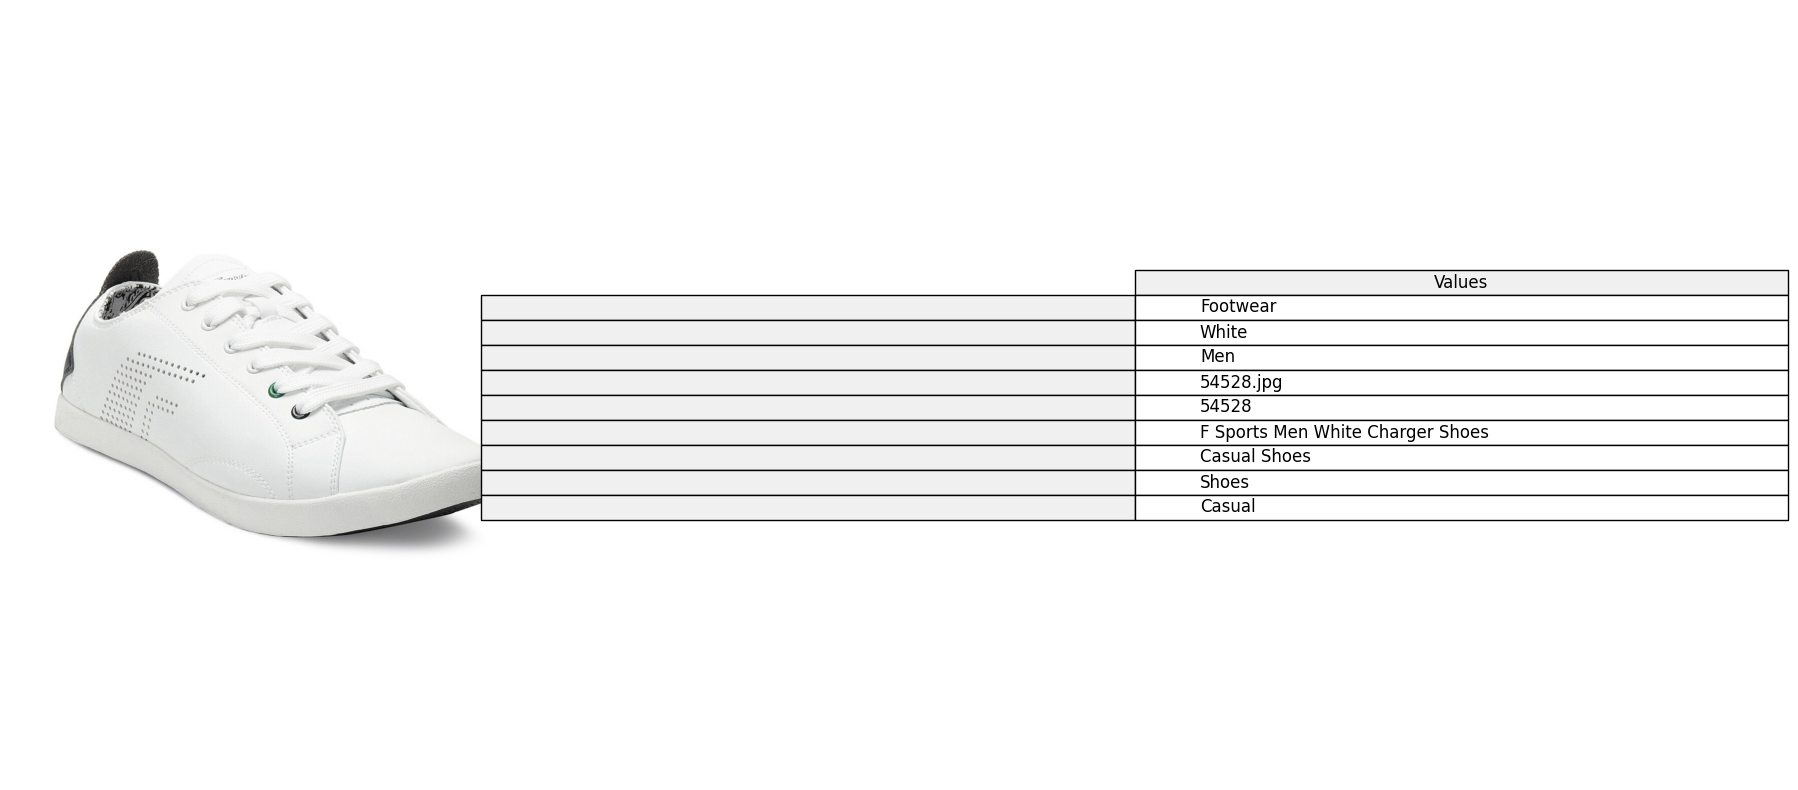

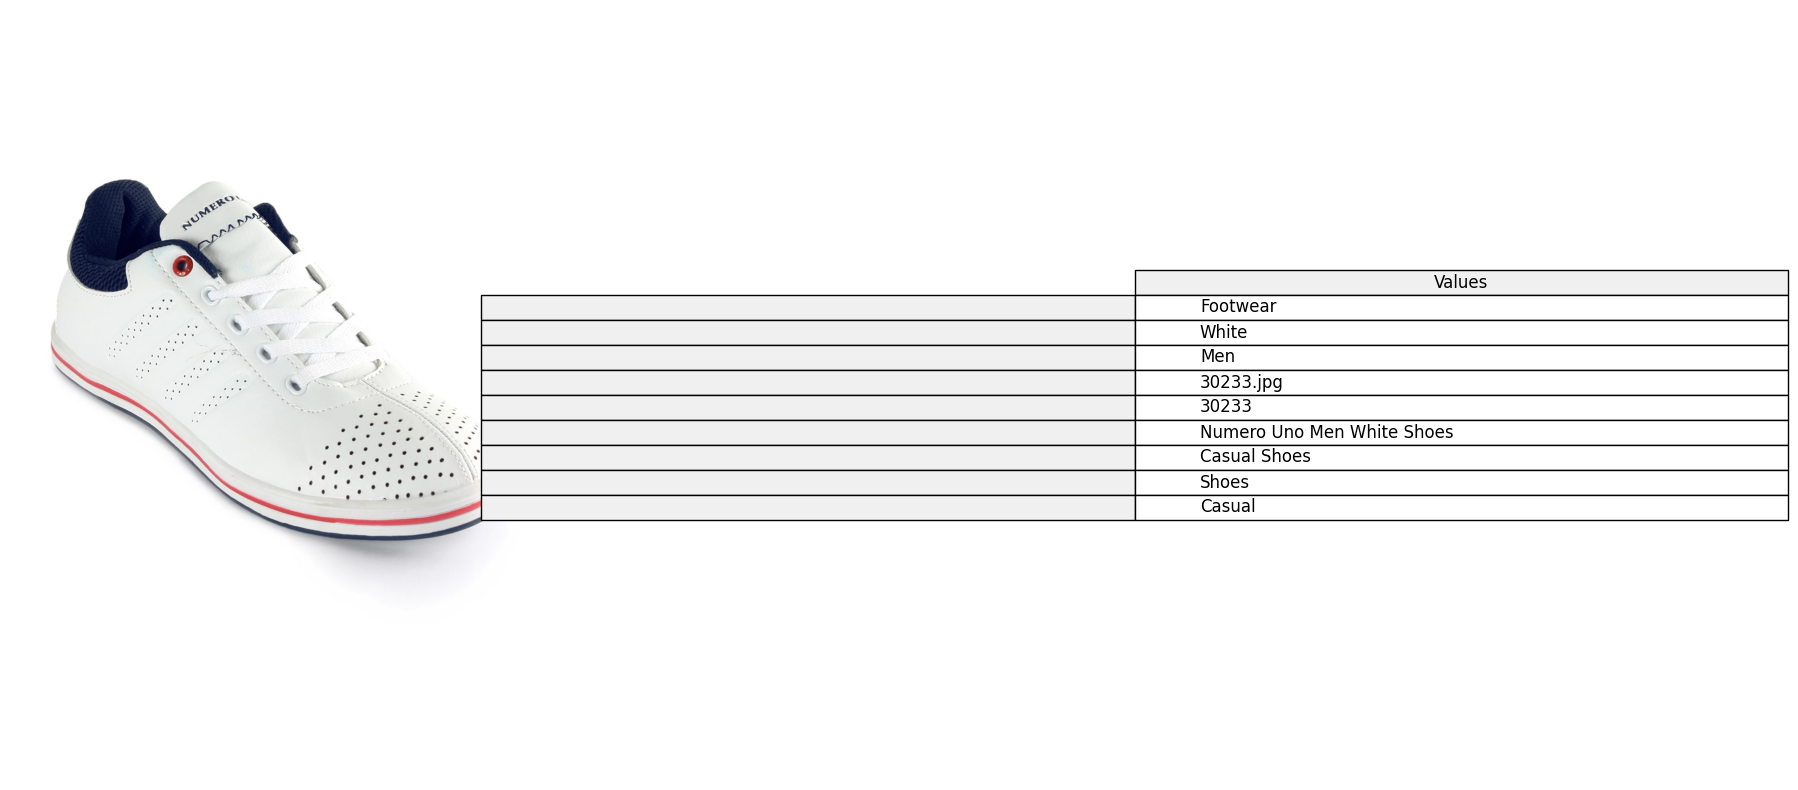

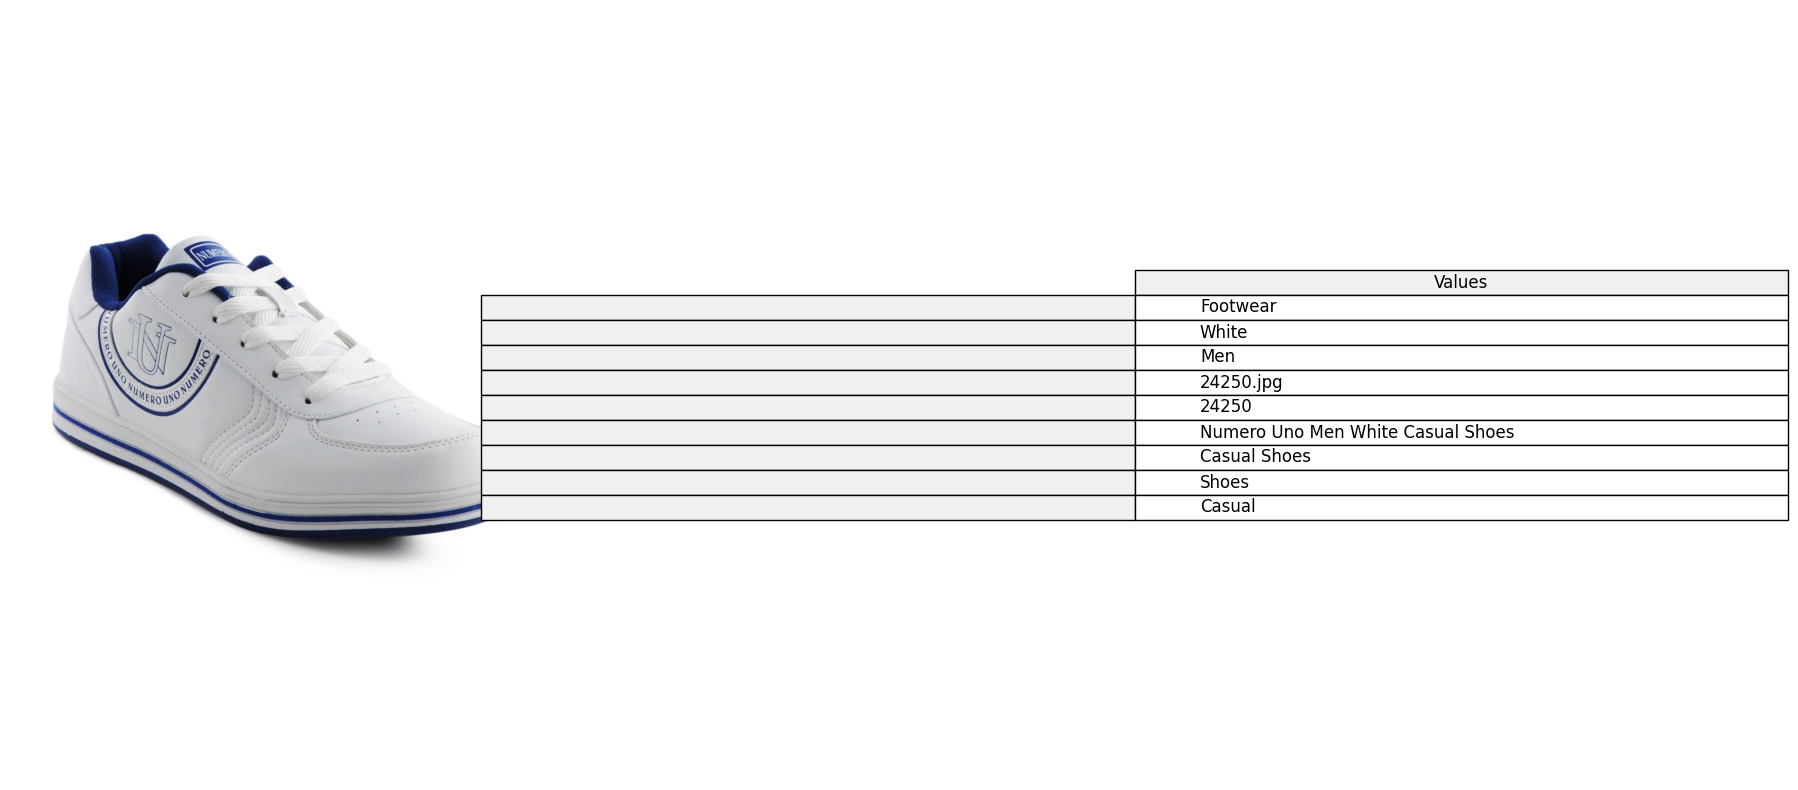

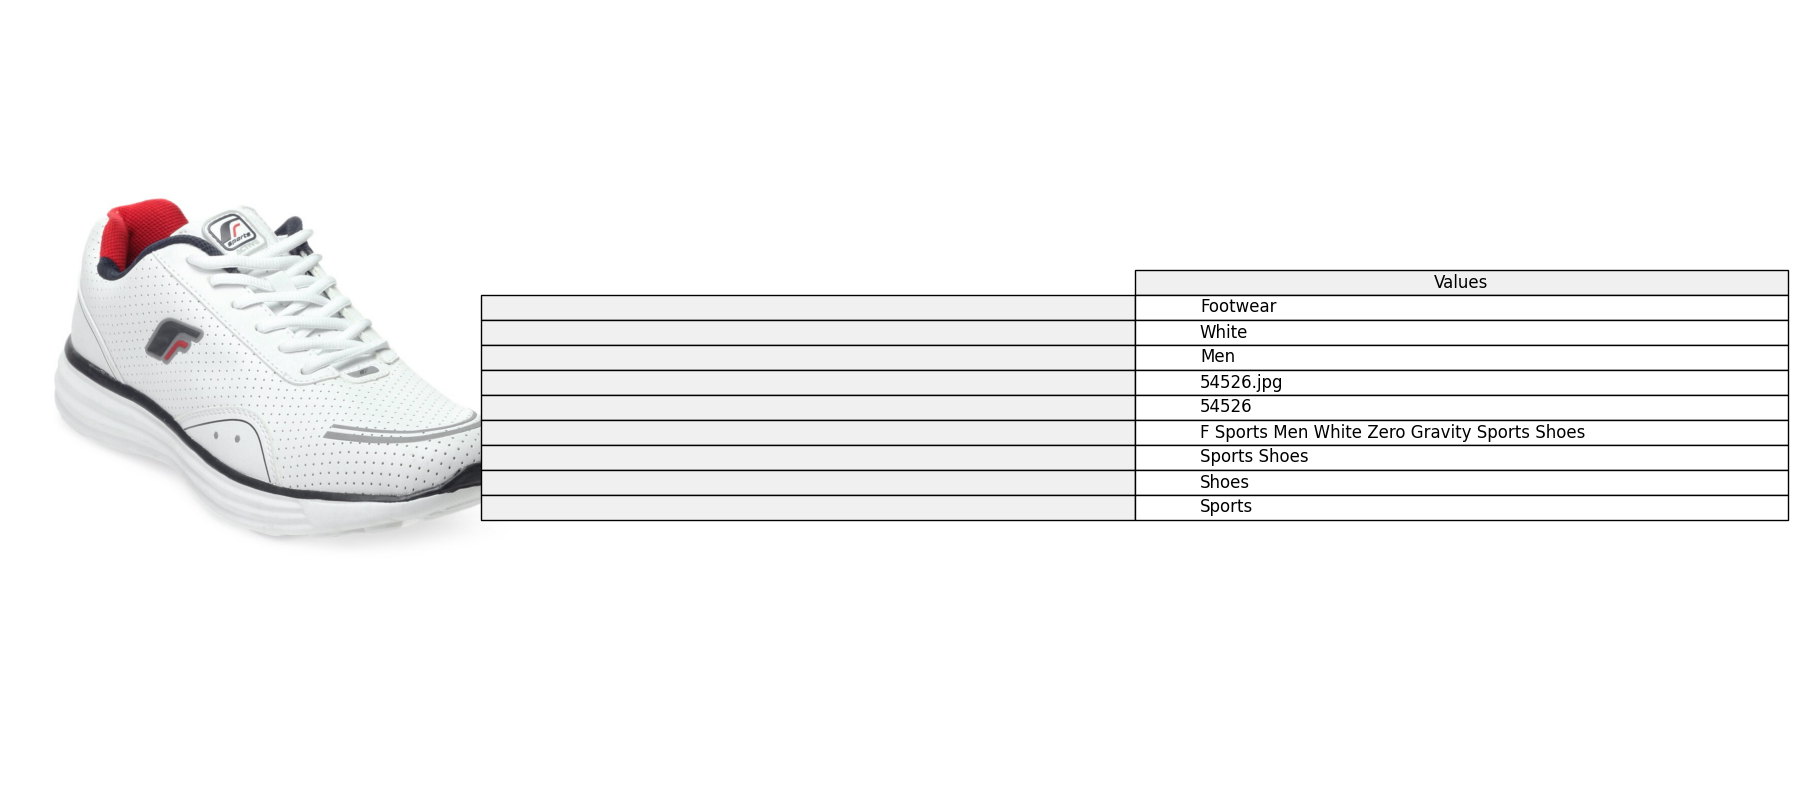

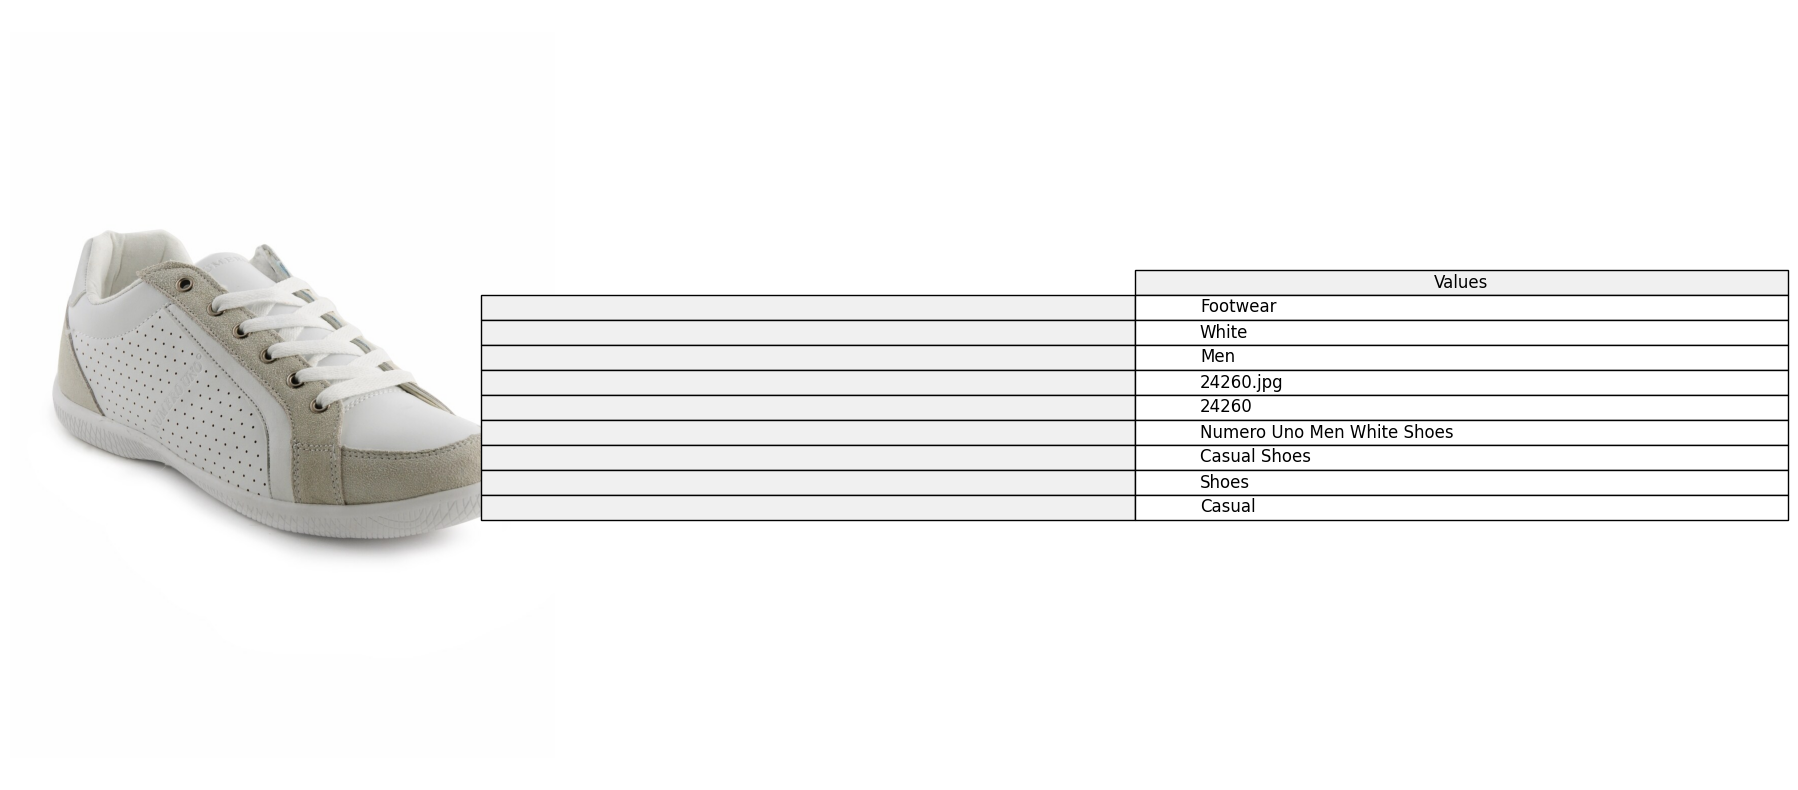

In [13]:
search_by_image(chroma_vector_store,('ex/3.jpg'),5)

## With search query using langchain

In [14]:
def search_by_query(vec_store, query):
    # First retriever with similarity_score_threshold
    chroma_retreiver = vec_store.as_retriever(
        search_type="similarity_score_threshold", 
        search_kwargs={"k": 5, "score_threshold": 0.1}
    )
    similar_images = chroma_retreiver.invoke(query)

    # If no results, fallback to other methods
    if not similar_images:
        chroma_retreiver = vec_store.as_retriever(
            search_type="mmr", 
            search_kwargs={'k': 5, 'fetch_k': 50}
        )
        similar_images = chroma_retreiver.invoke(query)

    if not similar_images:
        chroma_retreiver = vec_store.as_retriever(
            search_type="mmr", 
            search_kwargs={'k': 5, 'lambda_mult': 0.25}
        )
        similar_images = chroma_retreiver.invoke(query)

    get_images(similar_images)

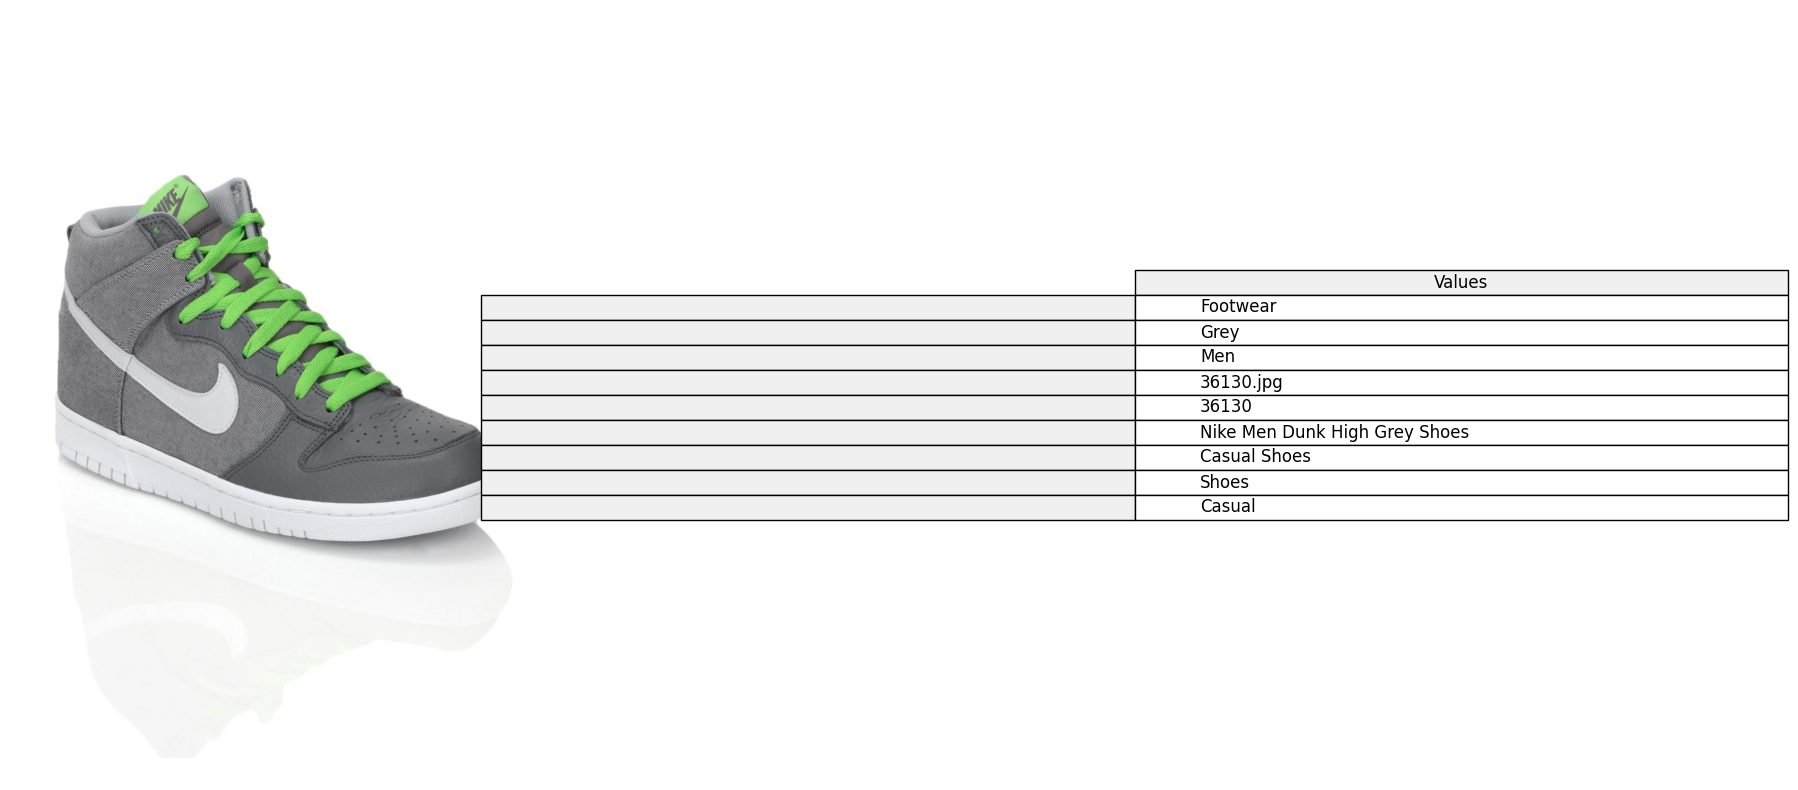

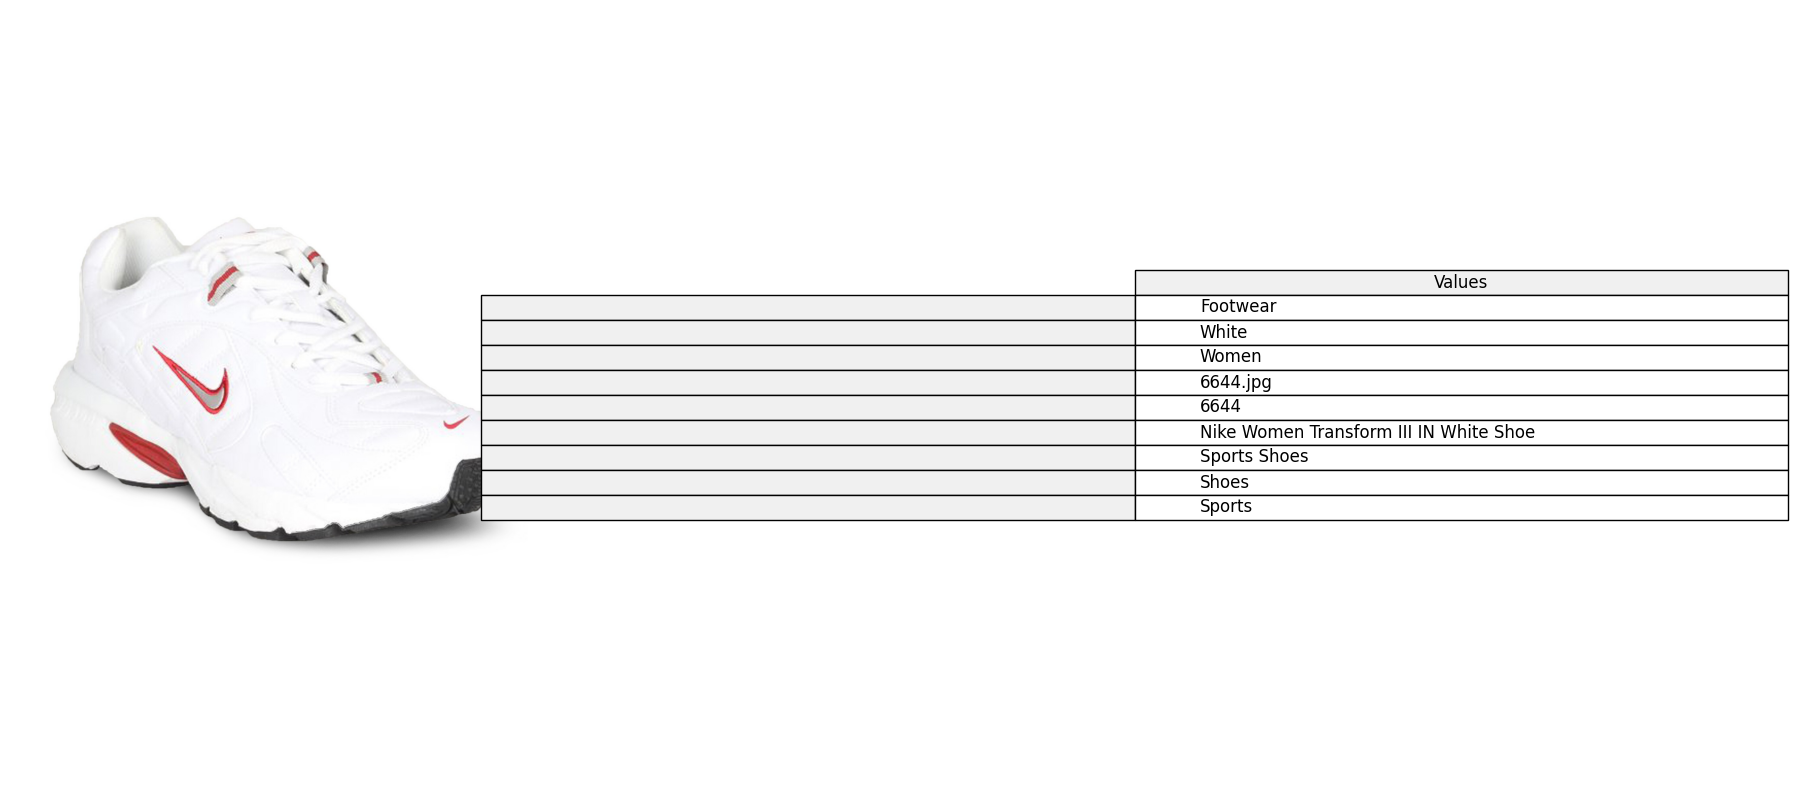

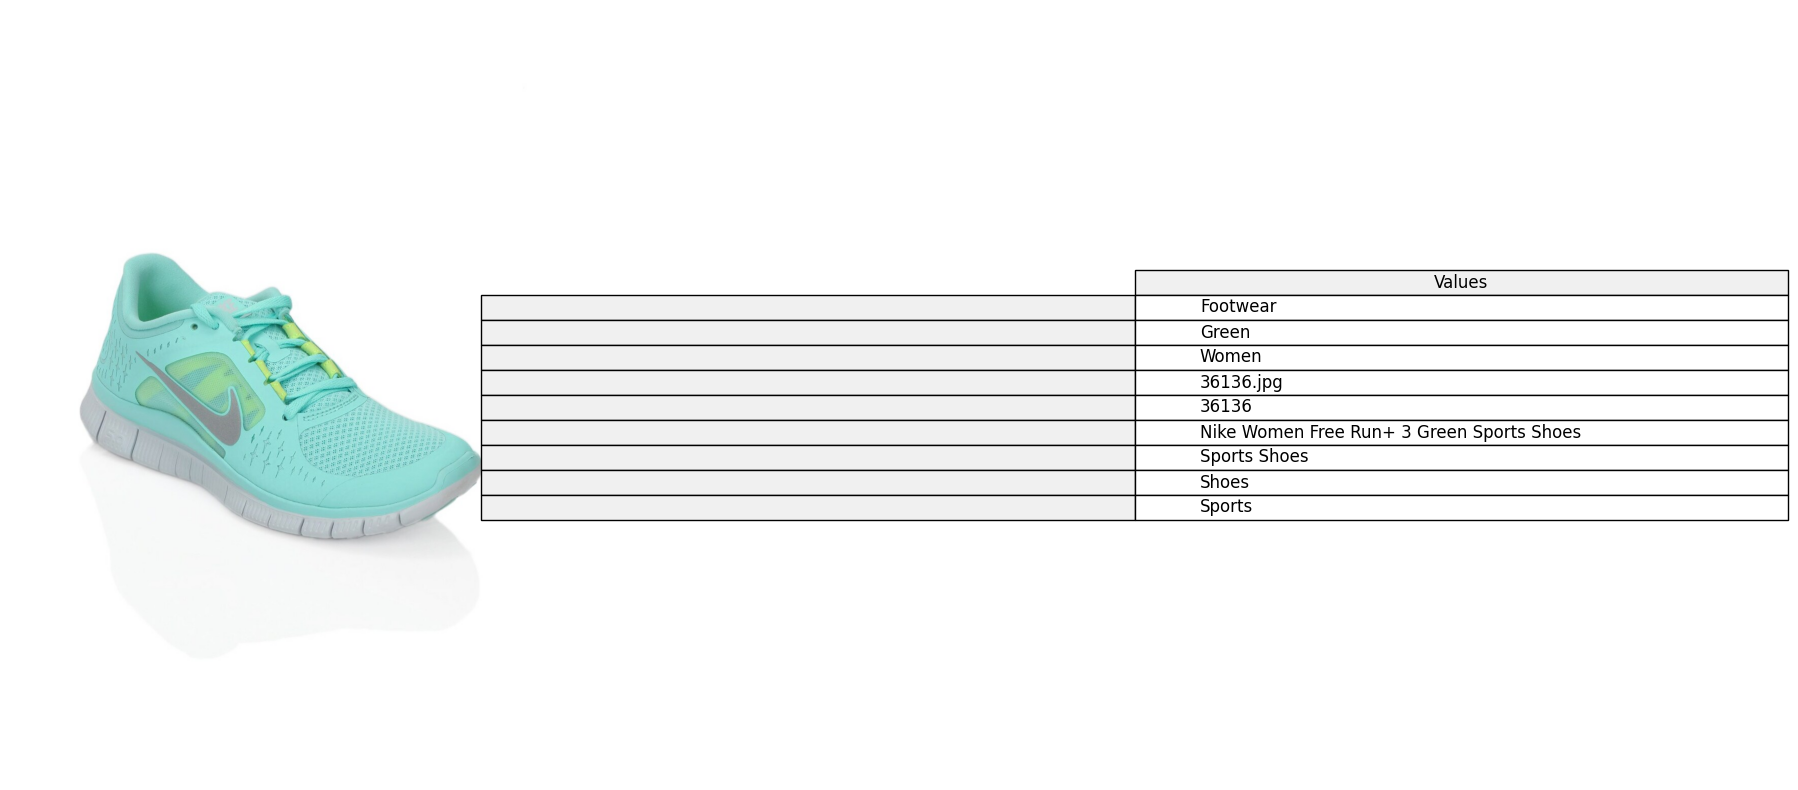

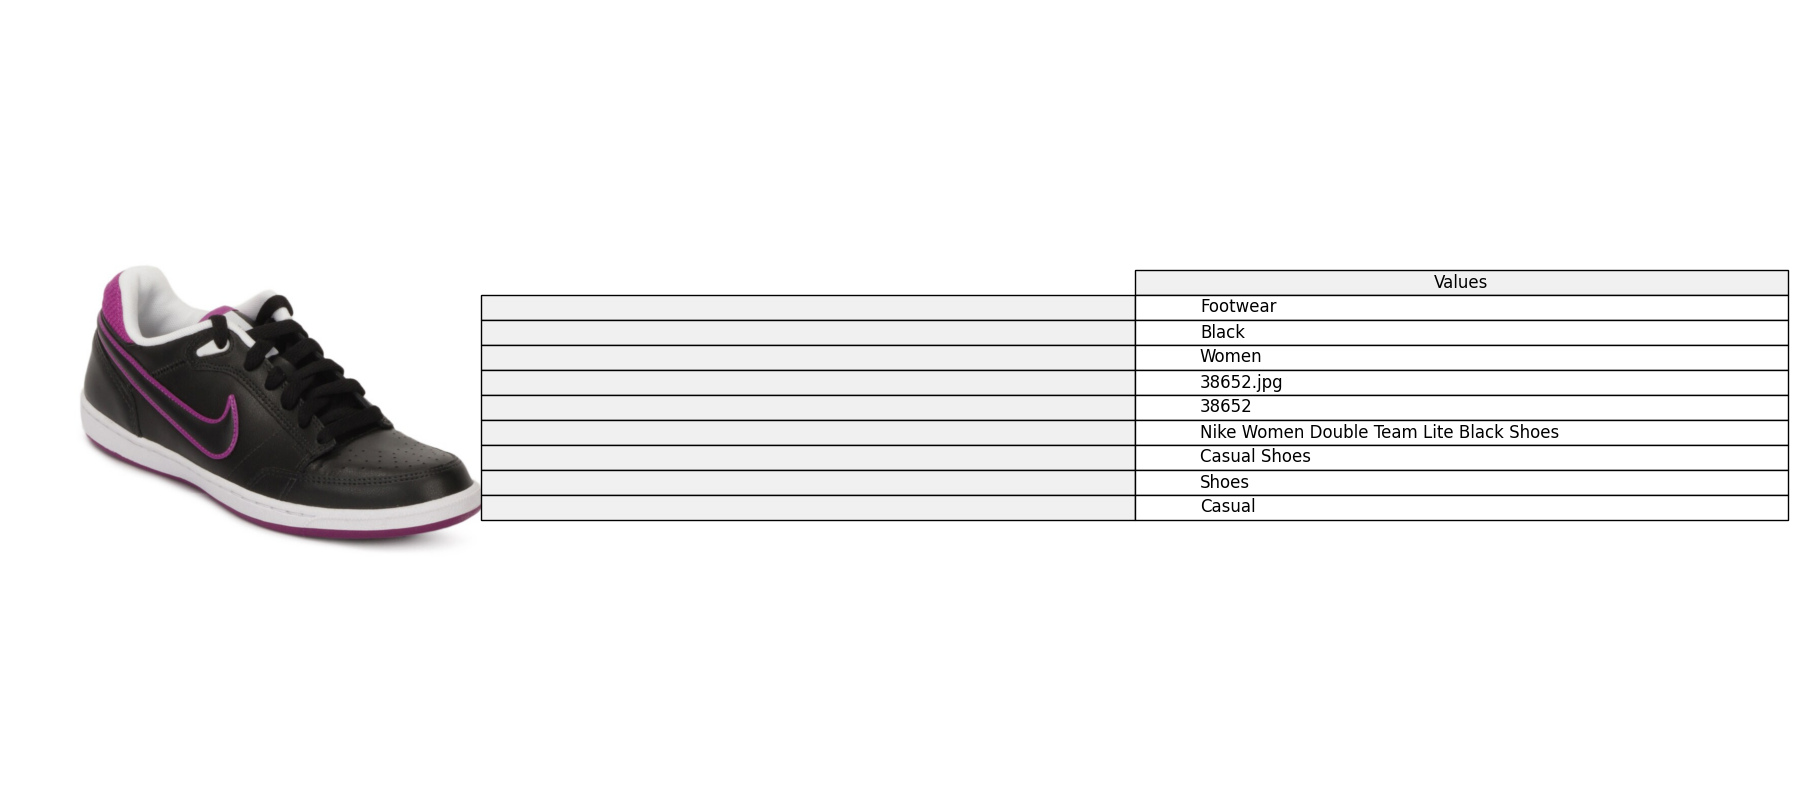

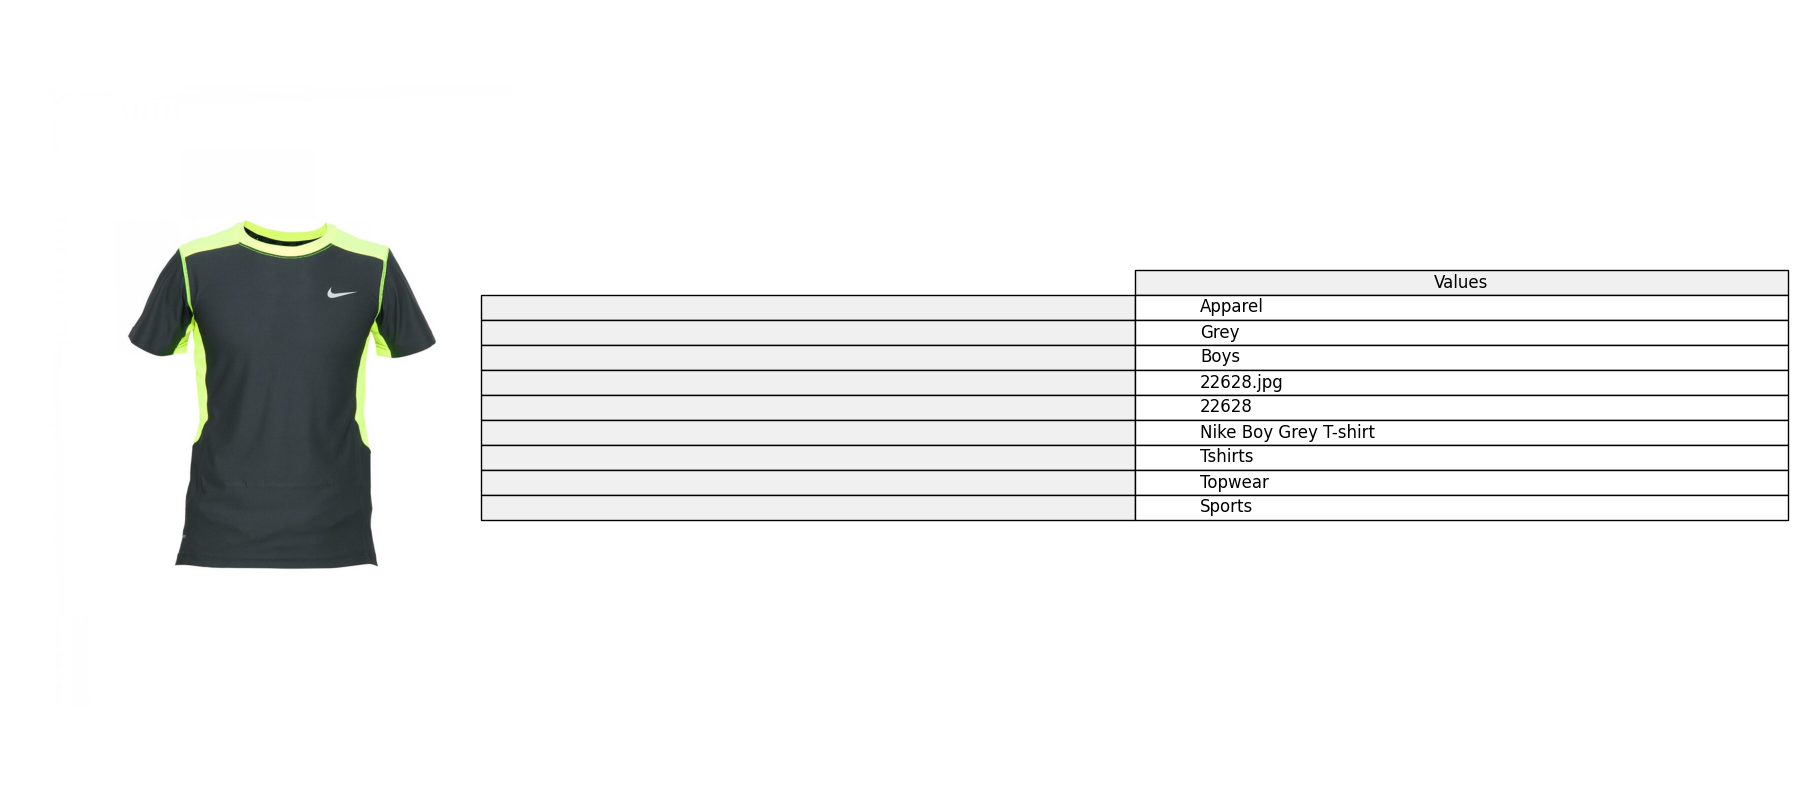

In [15]:
search_by_query(chroma_vector_store,"nike")